In [1]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import Counter
from wordcloud import WordCloud

# Load dữ liệu đã xử lý
PROCESSED_DATA_FILE = "../data/processed/processed_data.pt"
data = torch.load(PROCESSED_DATA_FILE)

# Kiểm tra số lượng mẫu trong tập train, val, test

In [22]:
print(f"Train samples: {len(data['train'])}")
print(f"Val samples: {len(data['val'])}")
print(f"Test samples: {len(data['test'])}")
print(f"Total samples: {len(data['train']) + len(data['val']) + len(data['test'])}")
print(f"Num answers: {len(data['answer_dict'])}")

Train samples: 27304
Val samples: 3424
Test samples: 3588
Total samples: 34316
Num answers: 274


In [21]:
metadata = data["metadata"]
print(
    f"Tổng số mẫu: Train={metadata['num_train']}, Val={metadata['num_val']}, Test={metadata['num_test']}"
)
print(f"Số lượng câu trả lời: {metadata['num_answers']}")
print(f"Số lượng ký tự trong vocab: {metadata['num_vocab']}\n")
print(len(data["answer_dict"]))

Tổng số mẫu: Train=27304, Val=3424, Test=3588
Số lượng câu trả lời: 274
Số lượng ký tự trong vocab: 88

274


## Kiểm tra vocab

In [4]:
vocab = data["vocab"]
print(f"Ví dụ 20 ký tự đầu tiên trong vocab: {list(vocab.keys())[:20]}")

Ví dụ 20 ký tự đầu tiên trong vocab: ['<PAD>', '<UNK>', 'Đ', 'â', 'y', ' ', 'l', 'à', 'q', 'u', 'ả', 'g', 'ì', '?', 'C', 'ó', 'b', 'a', 'o', 'n']


## Kiểm tra từ điển câu trả lời

In [5]:
answer_dict = data["answer_dict"]
print(f"Ví dụ 20 câu trả lời đầu tiên: {list(answer_dict.keys())[:20]}")

Ví dụ 20 câu trả lời đầu tiên: ['<UNK>', 'hạt dẻ', 'không rõ', 'nâu', '4', 'vải', '2', 'chiếu', 'xanh', 'cây', '5', 'bàn', 'lá khô', 'bát', '3', 'đĩa', '1', 'hộp', 'đất', 'xô']


## Biểu đồ phân bố số lượng ảnh trong train/val/test

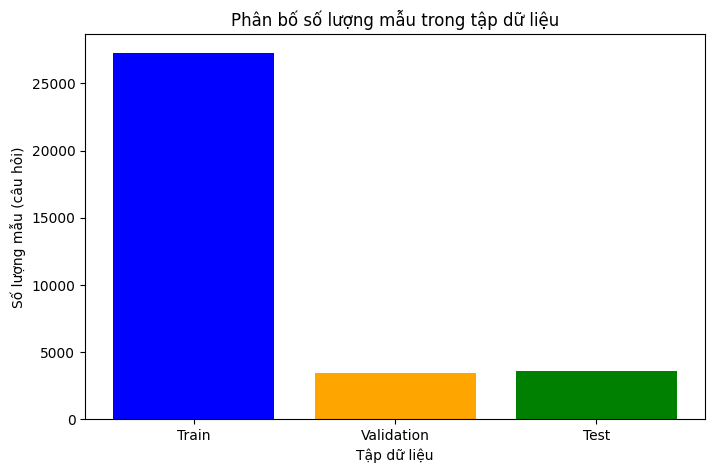

In [6]:
plt.figure(figsize=(8, 5))
plt.bar(
    ["Train", "Validation", "Test"],
    [metadata["num_train"], metadata["num_val"], metadata["num_test"]],
    color=["blue", "orange", "green"],
)
plt.xlabel("Tập dữ liệu")
plt.ylabel("Số lượng mẫu (câu hỏi)")
plt.title("Phân bố số lượng mẫu trong tập dữ liệu")
plt.show()

## Trực quan hóa dữ liệu mẫu từ tập train

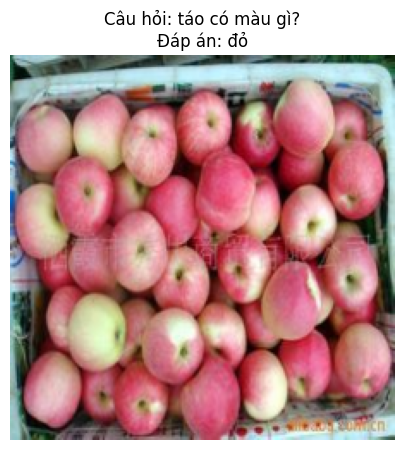


Mẫu 1:
- Câu hỏi: táo có màu gì?
- Đáp án: đỏ
- Tensor câu hỏi: [24, 57, 18, 5, 27, 15, 5, 28, 7, 9]... (độ dài: 14)
- ID đáp án: 66



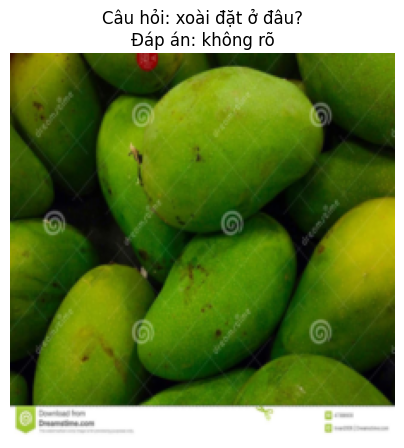


Mẫu 2:
- Câu hỏi: xoài đặt ở đâu?
- Đáp án: không rõ
- Tensor câu hỏi: [56, 18, 7, 21, 5, 29, 30, 24, 5, 31]... (độ dài: 15)
- ID đáp án: 2



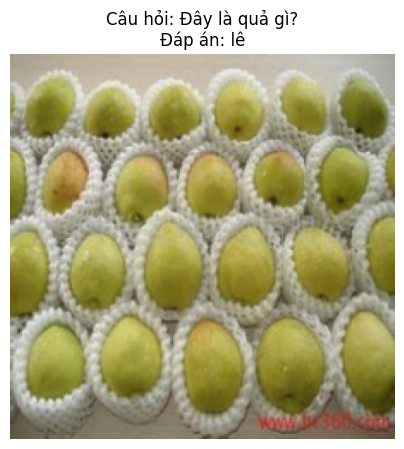


Mẫu 3:
- Câu hỏi: Đây là quả gì?
- Đáp án: lê
- Tensor câu hỏi: [2, 3, 4, 5, 6, 7, 5, 8, 9, 10]... (độ dài: 14)
- ID đáp án: 48



In [7]:
random_samples = random.sample(data["train"], min(3, len(data["train"])))

for i, sample in enumerate(random_samples):
    img_tensor = sample["image"]
    # Bỏ chuẩn hóa (unnormalize)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_tensor = img_tensor * std + mean
    img_tensor = torch.clamp(img_tensor, 0, 1)
    img_numpy = img_tensor.permute(1, 2, 0).numpy()

    # Giải mã câu hỏi
    question_tensor = sample["question"]
    question_text = "".join(
        [
            list(vocab.keys())[list(vocab.values()).index(i)]
            for i in question_tensor.tolist()
            if i != vocab["<PAD>"]
        ]
    )

    # Giải mã câu trả lời
    answer_id = sample["answer_id"].item()
    answer_text = list(answer_dict.keys())[list(answer_dict.values()).index(answer_id)]

    plt.figure(figsize=(5, 5))
    plt.imshow(img_numpy)
    plt.axis("off")
    plt.title(f"Câu hỏi: {question_text}\nĐáp án: {answer_text}", fontsize=12)
    plt.show()

    print(f"\nMẫu {i+1}:")
    print(f"- Câu hỏi: {question_text}")
    print(f"- Đáp án: {answer_text}")
    print(
        f"- Tensor câu hỏi: {question_tensor.tolist()[:10]}... (độ dài: {len(question_text)})"
    )
    print(f"- ID đáp án: {answer_id}\n")

## Biểu đồ phân bố độ dài câu hỏi

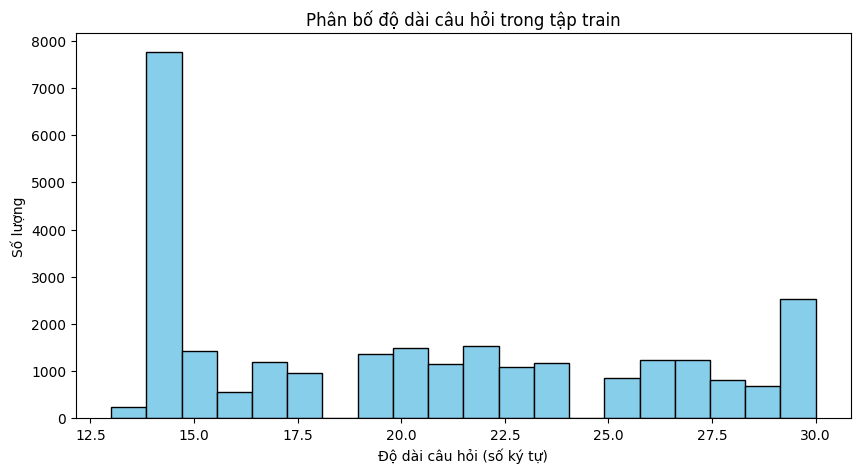

In [8]:
question_lengths = [
    len([i for i in sample["question"] if i != vocab["<PAD>"]])
    for sample in data["train"]
]
plt.figure(figsize=(10, 5))
plt.hist(question_lengths, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Độ dài câu hỏi (số ký tự)")
plt.ylabel("Số lượng")
plt.title("Phân bố độ dài câu hỏi trong tập train")
plt.show()

## Biểu đồ top câu hỏi phổ biến

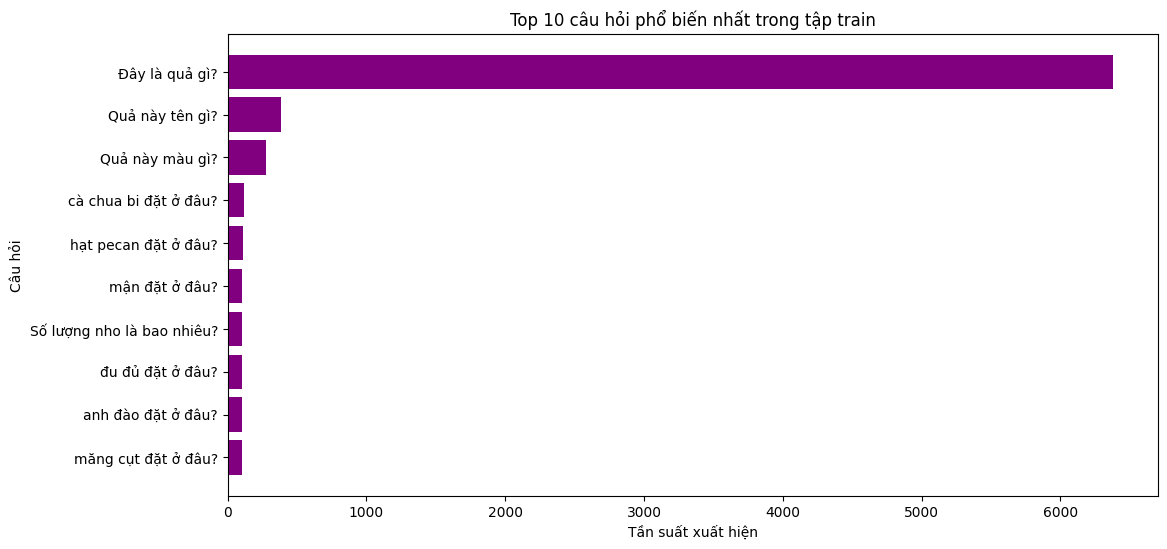

In [9]:
question_texts = [
    "".join(
        [
            list(vocab.keys())[list(vocab.values()).index(i)]
            for i in sample["question"]
            if i != vocab["<PAD>"]
        ]
    )
    for sample in data["train"]
]
question_counts = Counter(question_texts)
most_common_questions = dict(question_counts.most_common(10))  # Giảm xuống 10 cho gọn

plt.figure(figsize=(12, 6))
plt.barh(
    list(most_common_questions.keys()),
    list(most_common_questions.values()),
    color="purple",
)
plt.xlabel("Tần suất xuất hiện")
plt.ylabel("Câu hỏi")
plt.title("Top 10 câu hỏi phổ biến nhất trong tập train")
plt.gca().invert_yaxis()
plt.show()

## Biểu đồ số lượng câu trả lời phổ biến

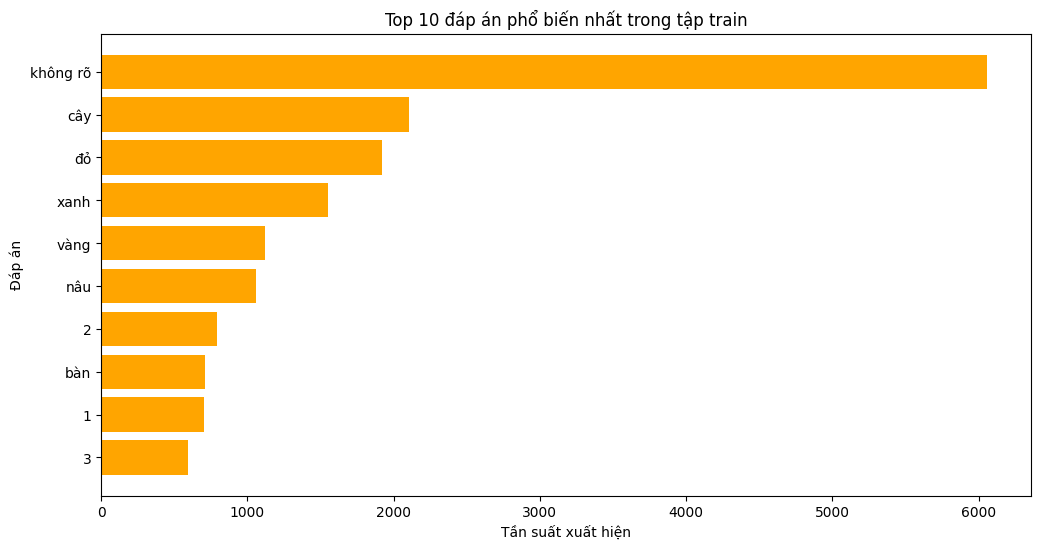

In [10]:
answer_counts = Counter(
    [
        list(answer_dict.keys())[
            list(answer_dict.values()).index(sample["answer_id"].item())
        ]
        for sample in data["train"]
    ]
)
most_common_answers = dict(answer_counts.most_common(10))  # Giảm xuống 10

plt.figure(figsize=(12, 6))
plt.barh(
    list(most_common_answers.keys()), list(most_common_answers.values()), color="orange"
)
plt.xlabel("Tần suất xuất hiện")
plt.ylabel("Đáp án")
plt.title("Top 10 đáp án phổ biến nhất trong tập train")
plt.gca().invert_yaxis()
plt.show()

## Thống kê "không rõ"

In [12]:
unclear_count = answer_counts["không rõ"]
print(
    f"Số lượng đáp án 'không rõ' trong tập train: {unclear_count} ({unclear_count / metadata['num_train'] * 100:.2f}%)\n"
)

Số lượng đáp án 'không rõ' trong tập train: 6057 (22.18%)



## WordCloud trực quan vocab

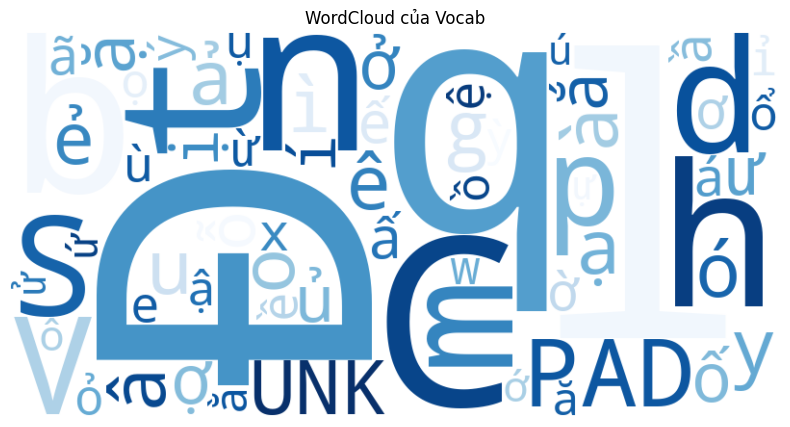

In [13]:
wordcloud_text = " ".join(vocab.keys())

wordcloud = WordCloud(
    width=800, height=400, background_color="white", colormap="Blues"
).generate(wordcloud_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud của Vocab")
plt.show()

## WordCloud trực quan câu hỏi

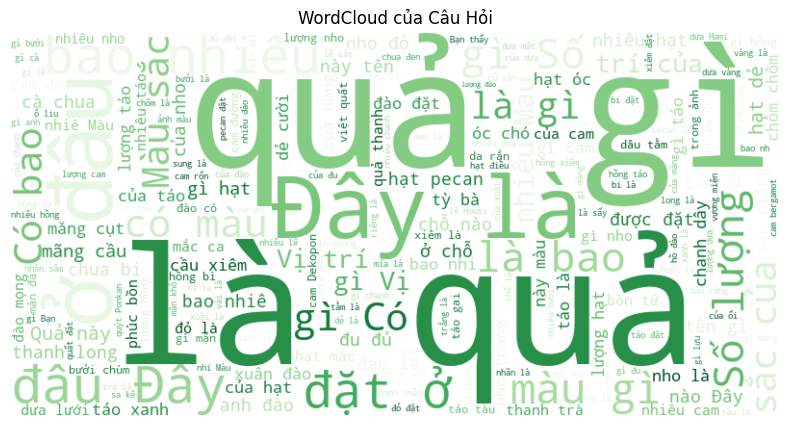

In [14]:
question_words = " ".join(question_texts)

wordcloud_questions = WordCloud(
    width=800, height=400, background_color="white", colormap="Greens"
).generate(question_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_questions, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud của Câu Hỏi")
plt.show()

##  WordCloud trực quan câu trả lời

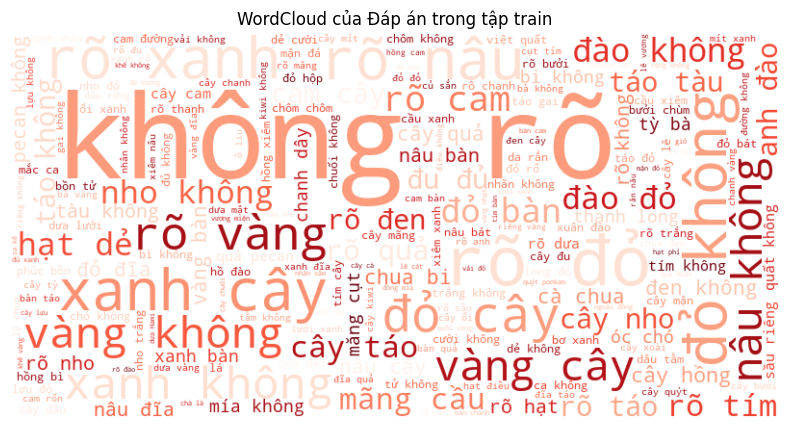

In [19]:
answer_words = " ".join(
    [
        list(answer_dict.keys())[
            list(answer_dict.values()).index(sample["answer_id"].item())
        ]
        for sample in data["train"]
    ]
)
wordcloud_answers = WordCloud(
    width=800, height=400, background_color="white", colormap="Reds"
).generate(answer_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_answers, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud của Đáp án trong tập train")
plt.show()